### 分析去除掉prompt biased tokens后的数据集上的精度变化

In [1]:
import torch

import numpy as np
from prettytable import PrettyTable


def show_dataset_info(root_dir, model, prompt):
    filter_token_nums = [0,1,2,4,8,16,32]
    table = PrettyTable()
    table.title = f"Dataset Variants {model} : {prompt}"
    table.add_column("Datasets", [ "LAMA", "WIKI-UNI", "LAMA-UHN"], )


    total_nums = None
    for num in filter_token_nums:
        if prompt != "optiprompt":
            data_dir = f"{root_dir}/manual_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}/debias_answer_type_tokens/origin_embedding/preds.pt"
        else:
            data_dir = f"{root_dir}/continue_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}_5/debias_answer_type_tokens/origin_embedding/exp_1/preds.pt"
        # 数据集数量变化
        data = torch.load(data_dir)
        datasets = ["LAMA", "WIKI-UNI", "LAMA-WHU"]
        datasets_num = []
        for _ in datasets:
            dataset = data[_]
            all_nums = []
            for relation in dataset.keys():
                number = len(dataset[relation]["data"]["obj_labels"])
                all_nums.append(number)
            datasets_num.append(np.sum(all_nums))

        if num==0:
            total_nums = datasets_num

        
        output_str = []
        for i,_num in enumerate(datasets_num):
            ratio = round(_num / total_nums[i] * 100)
            output_str.append("{}% ({})".format(ratio, _num))


        table.add_column("k={}".format(num), output_str)

    print(table)

        


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
from prettytable import PrettyTable

def show_acc_variance(root_dir, model, prompt):
    """绘制多个数据集变一下，三个手工prompt在debias后的精度变化"""
    k = [0,1,2,4,8,16,32]


    # 准备数据
    draw_datasets = {key:[] for key in ["LAMA", "WIKI-UNI", "LAMA-WHU"]}
    for num in k:
        data_dir = f"{root_dir}/filter_out_{num}_biased_tokens/{model}/common_vocab_cased/typed_querying/{prompt}_result.json"
        with open(data_dir) as f:
            data = json.load(f)
        for dataset in draw_datasets.keys():
            if prompt == 'optiprompt':
                key = 'optiprompt_5'
            else:
                key = prompt
            meta = data[model][dataset][key]
            diff = round((meta["P_d"] - meta["P"]) * 100, 2)
            draw_datasets[dataset].append(diff)
    
    # print(draw_datasets)

    legend_size =  8
    x_label_size = 14
    y_label_size = 14
    x_ticks = 14
    y_ticks = 15
    width=0.3
    fig1,axs1 = plt.subplots(1,1,figsize=(4,3))

    axs1.plot(k, draw_datasets["WIKI-UNI"], marker='o', label="WIKI-UNI")
    axs1.plot(k, draw_datasets["LAMA"], marker='o', label="LAMA")
    axs1.plot(k, draw_datasets["LAMA-WHU"],marker='o', label="LAMA-UHN")
    axs1.axhline(y=0, color='gray',linestyle='--',label='Acc Diff=0')
    axs1.legend(fontsize=legend_size)
    axs1.set_xlabel("K",fontsize=x_label_size,)
    axs1.set_ylabel("Accuracy Difference",fontsize=y_label_size,)
    axs1.set_xticks(k)


    table = PrettyTable()
    table.title = f"{model}-{prompt}"
    table.field_names = ["Datasets", 'k=0', 'k=1', 'k=2', 'k=4', 'k=8','k=16','k=32']
    table.add_row(["WIKI-UNI"]+draw_datasets["WIKI-UNI"])
    table.add_row(["LAMA"]+draw_datasets["LAMA"])
    table.add_row(["LAMA-WHU"]+draw_datasets["LAMA-WHU"])
    print(table)
    

    

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json

def show_raw_acc(root_dir, model, prompt):
    """绘制多个数据集变一下，三个手工prompt在debias后的精度变化"""
    k = [0,1,2,4,8,16,32]


    # 准备数据
    draw_datasets = {key:[] for key in ["LAMA", "WIKI-UNI", "LAMA-WHU"]}
    for num in k:
        data_dir = f"{root_dir}/filter_out_{num}_biased_tokens/{model}/common_vocab_cased/typed_querying/{prompt}_result.json"
        with open(data_dir) as f:
            data = json.load(f)
        for dataset in draw_datasets.keys():
            if prompt == 'optiprompt':
                key = 'optiprompt_5'
            else:
                key = prompt
            meta = data[model][dataset][key]
            raw = round((meta["P"]) * 100, 2)
            draw_datasets[dataset].append(raw)
    
    # print(draw_datasets)

    legend_size =  8
    x_label_size = 14
    y_label_size = 14
    x_ticks = 14
    y_ticks = 15
    width=0.3
    fig1,axs1 = plt.subplots(1,1,figsize=(4,3))

    axs1.plot(k, draw_datasets["WIKI-UNI"], marker='o', label="WIKI-UNI")
    axs1.plot(k, draw_datasets["LAMA"], marker='o', label="LAMA")
    axs1.plot(k, draw_datasets["LAMA-WHU"],marker='o', label="LAMA-UHN")
    axs1.axhline(y=0, color='gray',linestyle='--',label='Acc Diff=0')
    axs1.legend(fontsize=legend_size)
    axs1.set_xlabel("K",fontsize=x_label_size,)
    axs1.set_ylabel("Raw Accuracy",fontsize=y_label_size,)
    axs1.set_xticks(k)

    

In [7]:
def show_recall_ratio(root_dir, model, prompt):
    """统计不同数据集的recall ratio"""
    k = [0,1,2,4,8,16,32]


    # 准备数据
    draw_datasets = {key:[] for key in ["LAMA", "WIKI-UNI", "LAMA-WHU"]}
    for num in k:
        if prompt != "optiprompt":
            data_dir = f"{root_dir}/manual_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}/debias_answer_type_tokens/origin_embedding/preds.pt"
        else:
            data_dir = f"{root_dir}/continue_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}_5/debias_answer_type_tokens/origin_embedding/exp_1/preds.pt"
        # 数据集数量变化
        data = torch.load(data_dir)
        datasets = ["LAMA", "WIKI-UNI", "LAMA-WHU"]
        for _ in datasets:
            dataset = data[_]
            
            # 计算某个relation的公共进度
            preds_df = {rel:pd.DataFrame(dataset[rel]['data']) for rel in dataset.keys()}
            recall_ratios = []
            recall_nums = 0
            raw_nums = 0
            for rel in dataset.keys():
                df = preds_df[rel]
                recall_num_df = df.query("obj_labels==raw_preds and obj_labels==debiased_preds")
                raw_num_df = df.query("obj_labels==raw_preds")
                # acc = recall_ratio.shape[0]/df.shape[0]
                # recall_ratios[rel] = acc
                recall_nums += recall_num_df.shape[0] / df.shape[0]
                raw_nums += raw_num_df.shape[0] / df.shape[0]
                if raw_nums!=0:
                    recall_ratio = recall_nums / raw_nums
                    recall_ratios.append(recall_ratio)

            # draw_datasets[_].append(round((recall_nums/raw_nums)*100,2))
            draw_datasets[_].append(round(np.mean(recall_ratios)*100,2))




    legend_size =  8
    x_label_size = 14
    y_label_size = 14
    x_ticks = 14
    y_ticks = 15
    width=0.3
    fig1,axs1 = plt.subplots(1,1,figsize=(4,3))

    axs1.plot(k, draw_datasets["WIKI-UNI"], marker='o', label="WIKI-UNI")
    axs1.plot(k, draw_datasets["LAMA"], marker='o', label="LAMA")
    axs1.plot(k, draw_datasets["LAMA-WHU"],marker='o', label="LAMA-UHN")
    # axs1.axhline(y=0, color='gray',linestyle='--',label='Acc Diff=0')
    axs1.legend(fontsize=legend_size)
    axs1.set_xlabel("K",fontsize=x_label_size,)
    axs1.set_ylabel("Recall Ratio",fontsize=y_label_size,)
    axs1.set_xticks(k)


    table = PrettyTable()
    table.title = "{} {}".format(model, prompt)
    fields = ["Datasets"]
    for _ in k:
        fields.append(f"k={_}")
    table.field_names = fields
    for _ in draw_datasets.keys():
        table.add_row([_]+draw_datasets[_])
    print(table)

In [17]:
root_dir = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt"
show_dataset_info(root_dir, "bert-base-cased", "LAMA")
show_dataset_info(root_dir, "bert-base-cased", "LPAQA")
show_dataset_info(root_dir, "bert-base-cased", "AutoPrompt")
show_dataset_info(root_dir, "bert-base-cased", "optiprompt")

+-------------------------------------------------------------------------------------------------------------+
|                                   Dataset Variants bert-base-cased : LAMA                                   |
+----------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+
| Datasets |     k=0      |     k=1     |     k=2     |     k=4     |     k=8     |     k=16    |     k=32    |
+----------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   LAMA   | 100% (34017) | 96% (32572) | 89% (30346) | 80% (27366) | 73% (24823) | 61% (20860) | 47% (15832) |
| WIKI-UNI | 100% (62995) | 99% (62451) | 95% (59628) | 86% (53963) | 79% (49515) | 71% (45015) | 63% (39389) |
| LAMA-UHN | 100% (27102) | 96% (25972) | 88% (23916) | 79% (21521) | 71% (19326) | 60% (16142) | 45% (12121) |
+----------+--------------+-------------+-------------+-------------+-------------+-------------+-------

+------------------------------------------------------------------+
|                    bert-base-cased optiprompt                    |
+----------+-------+-------+-------+-------+-------+-------+-------+
| Datasets |  k=0  |  k=1  |  k=2  |  k=4  |  k=8  |  k=16 |  k=32 |
+----------+-------+-------+-------+-------+-------+-------+-------+
|   LAMA   | 49.21 | 63.03 | 70.01 | 73.28 | 78.97 | 83.19 | 85.45 |
| WIKI-UNI | 77.63 | 81.08 | 82.14 | 82.33 | 84.08 | 86.24 | 89.04 |
| LAMA-WHU | 33.64 | 48.01 |  57.7 | 59.97 |  68.5 | 73.92 |  76.9 |
+----------+-------+-------+-------+-------+-------+-------+-------+


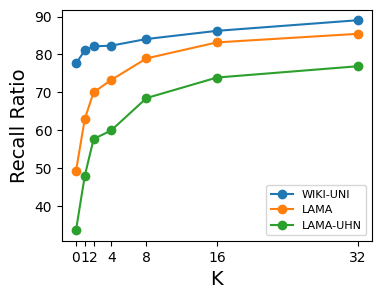

In [8]:
root_dir = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt"
# show_recall_ratio(root_dir, "bert-base-cased", "LAMA")
# show_recall_ratio(root_dir, "bert-base-cased", "LPAQA")
# show_recall_ratio(root_dir, "bert-base-cased", "AutoPrompt")
show_recall_ratio(root_dir, "bert-base-cased", "optiprompt")

+---------------------------------------------------------------+
|                      bert-base-cased-LAMA                     |
+----------+-------+-------+-------+------+------+------+-------+
| Datasets |  k=0  |  k=1  |  k=2  | k=4  | k=8  | k=16 |  k=32 |
+----------+-------+-------+-------+------+------+------+-------+
| WIKI-UNI |  4.17 |  4.8  |  5.34 | 6.75 | 6.17 | 6.73 |  8.38 |
|   LAMA   | -6.53 |  -3.9 | -1.58 | 2.08 | 2.5  | 4.89 | 10.32 |
| LAMA-WHU | -6.83 | -4.51 | -1.85 | 1.47 | 1.79 | 4.48 |  8.24 |
+----------+-------+-------+-------+------+------+------+-------+
+----------------------------------------------------------------+
|                     bert-base-cased-LPAQA                      |
+----------+--------+-------+-------+------+------+------+-------+
| Datasets |  k=0   |  k=1  |  k=2  | k=4  | k=8  | k=16 |  k=32 |
+----------+--------+-------+-------+------+------+------+-------+
| WIKI-UNI |  4.17  |  5.54 |  5.98 | 7.44 | 6.49 | 6.42 |  8.16 |
|   

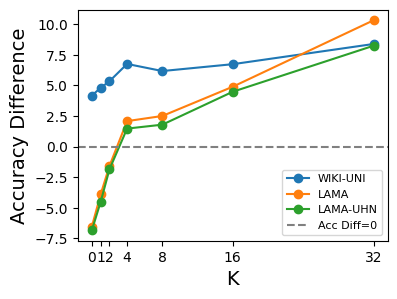

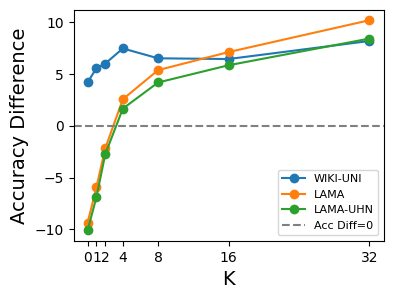

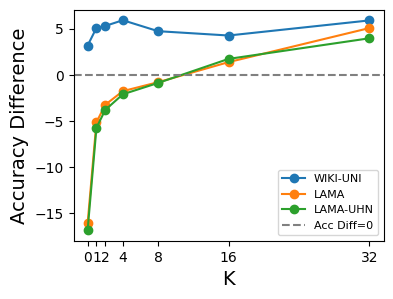

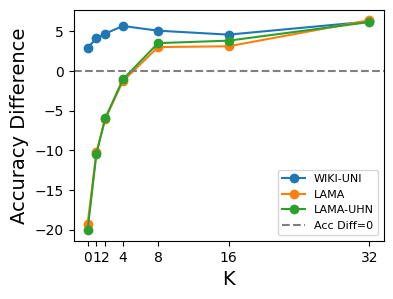

In [31]:
root_dir = "/mnt/code/users/xuziyang/PromptBias/results"
show_acc_variance(root_dir, "bert-base-cased", "LAMA")
show_acc_variance(root_dir, "bert-base-cased", "LPAQA")
show_acc_variance(root_dir, "bert-base-cased", "AutoPrompt")
show_acc_variance(root_dir, "bert-base-cased", "optiprompt")

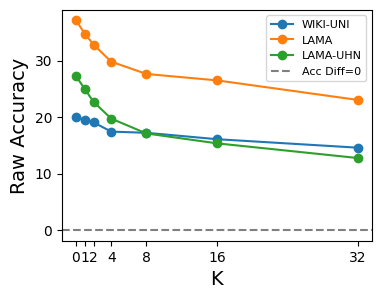

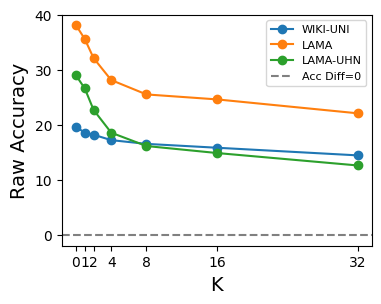

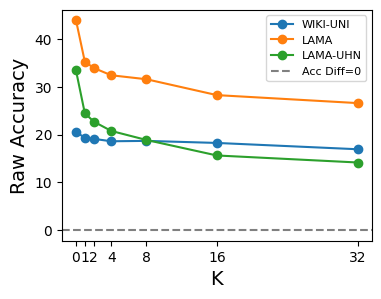

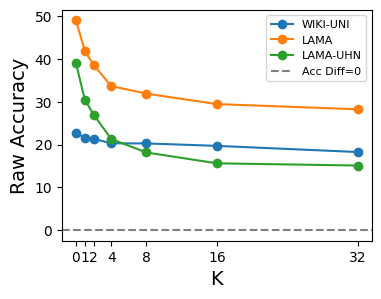

In [26]:
root_dir = "/mnt/code/users/xuziyang/PromptBias/results"
show_raw_acc(root_dir, "bert-base-cased", "LAMA")
show_raw_acc(root_dir, "bert-base-cased", "LPAQA")
show_raw_acc(root_dir, "bert-base-cased", "AutoPrompt")
show_raw_acc(root_dir, "bert-base-cased", "optiprompt")